# Forecast Forward with LGBM
Feature Engineering:
 - Datetime extraction
 - Introduce Phases
 - Use predicted average daily temperature to help fit model.

With LGBM, I will forecast up to March-31-2021. On January-01-2021, I'll change the Phases from Phase 4 to:
1. Phase -1: Coronavirus is over, return back to normal
2. Phase 4: Continue with Phase 4
3. Lockdown: Initiate Lockdown for January, and reopen on February

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import holidays

# For SARIMAX
from tqdm import tqdm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# For FBProphet
from fbprophet import Prophet

# For LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna

### Data Preprocessing
The original dataset can be found from data.ny.gov and time ranges from 2010-2020. <br>
https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga <br>
The counts are in hourly form and need to be resampled to Daily.
In addition, the bridges('plaza_id') are coded numerically and need to be renamed. <br>
Please note: I have combined Triboro Manhattan and Triboro Bronx into Triboro.

On 2017, NYC finished installing cashless tolls. I will, therefore, use data from 2018 and on because data was collected differently prior to 2017.

In [8]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    df = df.loc[df['Date_Hour'] >= '2018'].copy(deep=True)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df.drop(columns=['Plaza ID', 'Direction'], inplace=True)
    df.columns = ['datetime', 'ezpass', 'cash', 'plaza_id']
    _df = df.melt(id_vars=['datetime','plaza_id'], value_vars=['ezpass', 'cash'])
#     _df['crossing'] = _df['plaza_id'] + '_' + _df['variable']
    
#     _df.set_index('datetime', inplace=True)
#     _df = _df.groupby(['crossing'])['value'].resample('1D').sum()
#     _df = _df.unstack().T
    

    
    return _df


In [55]:
df = return_series('mta.csv')

In [57]:
df.set_index('datetime', inplace=True)
_df = df.groupby(['plaza_id', 'variable'])['value'].resample('1D').sum()
_df = _df.unstack().T

In [58]:
_df

plaza_id   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2018-01-01             3527  25636      1876  11829         5523  41017   
2018-01-02             4099  43061      2336  19539         5983  54627   
2018-01-03             4326  49679      2593  22014         6113  61870   
2018-01-04             1552  18932      1092   7211         1519  12983   
2018-01-05             3103  34904      1900  14939         4700  45150   
...                     ...    ...       ...    ...          ...    ...   
2020-10-06             7093  48860      3385  18802         7695  52157   
2020-10-07             7090  48514      3227  18876         8126  53803   
2020-10-08             7313  49405      3313  19392         8370  55294   
2020-10-09             7540  46132      3402  19839        10035  60207   
2020-10-10             6316  34818      3177  16757        10105  51852   

plaza_id   Marine Parkway        Queens Midtown        Throgs Neck          \
variable             cash ezpass           cash ezpass        cash  ezpass   
datetime                                                                     
2018-01-01           1096  11022           7338  47569       16177   82169   
2018-01-02           1517  18370           6554  60446       12971   93293   
2018-01-03           1635  20432           7071  64654       13045  102907   
2018-01-04            571   5596           2687  23938        3518   24888   
2018-01-05           1102  12827           5465  49688        9585   70892   
...                   ...    ...            ...    ...         ...     ...   
2020-10-06           2518  18667          10831  52764       14178   83961   
2020-10-07           2476  17918          11425  56360       14752   86849   
2020-10-08           2559  18748          11800  58204       15760   90958   
2020-10-09           2531  17999          13433  61760       17321   95125   
2020-10-10           2605  16447          12107  48178       19018   91976   

plaza_id   Triboro         Verrazano        Whitestone          
variable      cash  ezpass      cash ezpass       cash  ezpass  
datetime                                                        
2018-01-01   22395  118380     11583  70340      18818   90468  
2018-01-02   20751  144179      9319  86330      14843  102368  
2018-01-03   21182  153968      9110  94396      15263  108711  
2018-01-04    7787   56350      3319  34501       4855   33259  
2018-01-05   16429  118824      6841  67534      11586   79643  
...            ...     ...       ...    ...        ...     ...  
2020-10-06   26219  130693     11193  86130      20675  101180  
2020-10-07   26443  134036     11166  86913      20208   99960  
2020-10-08   28160  140175     11907  88834      21469  104514  
2020-10-09   30816  142961     13464  93085      25545  119287  
2020-10-10   32227  132258     14218  85350      26894  111136  

[1014 rows x 18 columns]

In [59]:
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [62]:
_df.reset_index(inplace=True)

In [12]:
df['value'] = df['value'].replace(to_replace=0, value=np.nan)

In [19]:
df['value'] = df['value'].fillna(value=0)

In [21]:
df.set_index('datetime', inplace=True)

In [23]:
_df = df.groupby(['plaza_id', 'variable'])['value'].resample('1D').sum()

In [24]:
_df = _df.unstack().T

In [25]:
_df

plaza_id   Brooklyn Battery          Cross Bay          Henry Hudson           \
variable               cash   ezpass      cash   ezpass         cash   ezpass   
datetime                                                                        
2018-01-01           3527.0  25636.0    1876.0  11829.0       5523.0  41017.0   
2018-01-02           4099.0  43061.0    2336.0  19539.0       5983.0  54627.0   
2018-01-03           4326.0  49679.0    2593.0  22014.0       6113.0  61870.0   
2018-01-04           1552.0  18932.0    1092.0   7211.0       1519.0  12983.0   
2018-01-05           3103.0  34904.0    1900.0  14939.0       4700.0  45150.0   
...                     ...      ...       ...      ...          ...      ...   
2020-10-06           7093.0  48860.0    3385.0  18802.0       7695.0  52157.0   
2020-10-07           7090.0  48514.0    3227.0  18876.0       8126.0  53803.0   
2020-10-08           7313.0  49405.0    3313.0  19392.0       8370.0  55294.0   
2020-10-09           7540.0  46132.0    3402.0  19839.0      10035.0  60207.0   
2020-10-10           6316.0  34818.0    3177.0  16757.0      10105.0  51852.0   

plaza_id   Marine Parkway          Queens Midtown          Throgs Neck  \
variable             cash   ezpass           cash   ezpass        cash   
datetime                                                                 
2018-01-01         1096.0  11022.0         7338.0  47569.0     16177.0   
2018-01-02         1517.0  18370.0         6554.0  60446.0     12971.0   
2018-01-03         1635.0  20432.0         7071.0  64654.0     13045.0   
2018-01-04          571.0   5596.0         2687.0  23938.0      3518.0   
2018-01-05         1102.0  12827.0         5465.0  49688.0      9585.0   
...                   ...      ...            ...      ...         ...   
2020-10-06         2518.0  18667.0        10831.0  52764.0     14178.0   
2020-10-07         2476.0  17918.0        11425.0  56360.0     14752.0   
2020-10-08         2559.0  18748.0        11800.0  58204.0     15760.0   
2020-10-09         2531.0  17999.0        13433.0  61760.0     17321.0   
2020-10-10         2605.0  16447.0        12107.0  48178.0     19018.0   

plaza_id              Triboro           Verrazano          Whitestone  \
variable      ezpass     cash    ezpass      cash   ezpass       cash   
datetime                                                                
2018-01-01   82169.0  22395.0  118380.0   11583.0  70340.0    18818.0   
2018-01-02   93293.0  20751.0  144179.0    9319.0  86330.0    14843.0   
2018-01-03  102907.0  21182.0  153968.0    9110.0  94396.0    15263.0   
2018-01-04   24888.0   7787.0   56350.0    3319.0  34501.0     4855.0   
2018-01-05   70892.0  16429.0  118824.0    6841.0  67534.0    11586.0   
...              ...      ...       ...       ...      ...        ...   
2020-10-06   83961.0  26219.0  130693.0   11193.0  86130.0    20675.0   
2020-10-07   86849.0  26443.0  134036.0   11166.0  86913.0    20208.0   
2020-10-08   90958.0  28160.0  140175.0   11907.0  88834.0    21469.0   
2020-10-09   95125.0  30816.0  142961.0   13464.0  93085.0    25545.0   
2020-10-10   91976.0  32227.0  132258.0   14218.0  85350.0    26894.0   

plaza_id              
variable      ezpass  
datetime              
2018-01-01   90468.0  
2018-01-02  102368.0  
2018-01-03  108711.0  
2018-01-04   33259.0  
2018-01-05   79643.0  
...              ...  
2020-10-06  101180.0  
2020-10-07   99960.0  
2020-10-08  104514.0  
2020-10-09  119287.0  
2020-10-10  111136.0  

[1014 rows x 18 columns]

In [54]:
_df

plaza_id   Brooklyn Battery          Cross Bay          Henry Hudson           \
variable               cash   ezpass      cash   ezpass         cash   ezpass   
datetime                                                                        
2018-01-01           3527.0  25636.0    1876.0  11829.0       5523.0  41017.0   
2018-01-02           4099.0  43061.0    2336.0  19539.0       5983.0  54627.0   
2018-01-03           4326.0  49679.0    2593.0  22014.0       6113.0  61870.0   
2018-01-04           1552.0  18932.0    1092.0   7211.0       1519.0  12983.0   
2018-01-05           3103.0  34904.0    1900.0  14939.0       4700.0  45150.0   
...                     ...      ...       ...      ...          ...      ...   
2020-10-06           7093.0  48860.0    3385.0  18802.0       7695.0  52157.0   
2020-10-07           7090.0  48514.0    3227.0  18876.0       8126.0  53803.0   
2020-10-08           7313.0  49405.0    3313.0  19392.0       8370.0  55294.0   
2020-10-09           7540.0  46132.0    3402.0  19839.0      10035.0  60207.0   
2020-10-10           6316.0  34818.0    3177.0  16757.0      10105.0  51852.0   

plaza_id   Marine Parkway          Queens Midtown           ... month  \
variable             cash   ezpass           cash   ezpass  ...         
datetime                                                    ...         
2018-01-01         1096.0  11022.0         7338.0  47569.0  ...     1   
2018-01-02         1517.0  18370.0         6554.0  60446.0  ...     1   
2018-01-03         1635.0  20432.0         7071.0  64654.0  ...     1   
2018-01-04          571.0   5596.0         2687.0  23938.0  ...     1   
2018-01-05         1102.0  12827.0         5465.0  49688.0  ...     1   
...                   ...      ...            ...      ...  ...   ...   
2020-10-06         2518.0  18667.0        10831.0  52764.0  ...    10   
2020-10-07         2476.0  17918.0        11425.0  56360.0  ...    10   
2020-10-08         2559.0  18748.0        11800.0  58204.0  ...    10   
2020-10-09         2531.0  17999.0        13433.0  61760.0  ...    10   
2020-10-10         2605.0  16447.0        12107.0  48178.0  ...    10   

plaza_id   dayofweek  year week day quarter dayofyear Phase weekend holiday  
variable                                                                     
datetime                                                                     
2018-01-01         0  2018    1   1       1         1    -1       0       1  
2018-01-02         1  2018    1   2       1         2    -1       0       0  
2018-01-03         2  2018    1   3       1         3    -1       0       0  
2018-01-04         3  2018    1   4       1         4    -1       0       0  
2018-01-05         4  2018    1   5       1         5    -1       0       0  
...              ...   ...  ...  ..     ...       ...   ...     ...     ...  
2020-10-06         1  2020   41   6       4       280     7       0       0  
2020-10-07         2  2020   41   7       4       281     7       0       0  
2020-10-08         3  2020   41   8       4       282     7       0       0  
2020-10-09         4  2020   41   9       4       283     7       0       0  
2020-10-10         5  2020   41  10       4       284     7       1       0  

[1014 rows x 28 columns]

### 9 Toll Bridges in NYC

There are some days when there were 0 crossings over bridges. (missing values). <br> For this project, I have decided to fill the missing values with the previous day count. <br>





In [26]:

for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [27]:
_df

plaza_id   Brooklyn Battery          Cross Bay          Henry Hudson           \
variable               cash   ezpass      cash   ezpass         cash   ezpass   
datetime                                                                        
2018-01-01           3527.0  25636.0    1876.0  11829.0       5523.0  41017.0   
2018-01-02           4099.0  43061.0    2336.0  19539.0       5983.0  54627.0   
2018-01-03           4326.0  49679.0    2593.0  22014.0       6113.0  61870.0   
2018-01-04           1552.0  18932.0    1092.0   7211.0       1519.0  12983.0   
2018-01-05           3103.0  34904.0    1900.0  14939.0       4700.0  45150.0   
...                     ...      ...       ...      ...          ...      ...   
2020-10-06           7093.0  48860.0    3385.0  18802.0       7695.0  52157.0   
2020-10-07           7090.0  48514.0    3227.0  18876.0       8126.0  53803.0   
2020-10-08           7313.0  49405.0    3313.0  19392.0       8370.0  55294.0   
2020-10-09           7540.0  46132.0    3402.0  19839.0      10035.0  60207.0   
2020-10-10           6316.0  34818.0    3177.0  16757.0      10105.0  51852.0   

plaza_id   Marine Parkway          Queens Midtown          Throgs Neck  \
variable             cash   ezpass           cash   ezpass        cash   
datetime                                                                 
2018-01-01         1096.0  11022.0         7338.0  47569.0     16177.0   
2018-01-02         1517.0  18370.0         6554.0  60446.0     12971.0   
2018-01-03         1635.0  20432.0         7071.0  64654.0     13045.0   
2018-01-04          571.0   5596.0         2687.0  23938.0      3518.0   
2018-01-05         1102.0  12827.0         5465.0  49688.0      9585.0   
...                   ...      ...            ...      ...         ...   
2020-10-06         2518.0  18667.0        10831.0  52764.0     14178.0   
2020-10-07         2476.0  17918.0        11425.0  56360.0     14752.0   
2020-10-08         2559.0  18748.0        11800.0  58204.0     15760.0   
2020-10-09         2531.0  17999.0        13433.0  61760.0     17321.0   
2020-10-10         2605.0  16447.0        12107.0  48178.0     19018.0   

plaza_id              Triboro           Verrazano          Whitestone  \
variable      ezpass     cash    ezpass      cash   ezpass       cash   
datetime                                                                
2018-01-01   82169.0  22395.0  118380.0   11583.0  70340.0    18818.0   
2018-01-02   93293.0  20751.0  144179.0    9319.0  86330.0    14843.0   
2018-01-03  102907.0  21182.0  153968.0    9110.0  94396.0    15263.0   
2018-01-04   24888.0   7787.0   56350.0    3319.0  34501.0     4855.0   
2018-01-05   70892.0  16429.0  118824.0    6841.0  67534.0    11586.0   
...              ...      ...       ...       ...      ...        ...   
2020-10-06   83961.0  26219.0  130693.0   11193.0  86130.0    20675.0   
2020-10-07   86849.0  26443.0  134036.0   11166.0  86913.0    20208.0   
2020-10-08   90958.0  28160.0  140175.0   11907.0  88834.0    21469.0   
2020-10-09   95125.0  30816.0  142961.0   13464.0  93085.0    25545.0   
2020-10-10   91976.0  32227.0  132258.0   14218.0  85350.0    26894.0   

plaza_id              
variable      ezpass  
datetime              
2018-01-01   90468.0  
2018-01-02  102368.0  
2018-01-03  108711.0  
2018-01-04   33259.0  
2018-01-05   79643.0  
...              ...  
2020-10-06  101180.0  
2020-10-07   99960.0  
2020-10-08  104514.0  
2020-10-09  119287.0  
2020-10-10  111136.0  

[1014 rows x 18 columns]

### Feature Engineering: Holidays
Holidays will be an important feature in determining daily toll traffic. I created a list of all the holidays from 2018-2021.

In [67]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020, 2021]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])
        
crossing_rates = {('Brooklyn Battery', 'cash'):9.50,
                 ('Brooklyn Battery', 'ezpass'):6.12,
                 ('Cross Bay', 'cash'):4.75,
                 ('Cross Bay', 'ezpass'):2.29,
                 ('Henry Hudson','cash'):7.00,
                 ('Henry Hudson','ezpass'):2.80,
                 ('Marine Parkway','cash'):4.75,
                 ('Marine Parkway','ezpass'):2.29,
                 ('Queens Midtown','cash'):9.50,
                 ('Queens Midtown','ezpass'):6.12,
                 ('Throgs Neck','cash'): 9.50,
                 ('Throgs Neck','ezpass'): 6.12,
                 ('Triboro','cash'): 9.50,
                 ('Triboro','ezpass'):6.12,
                 ('Verrazano','cash'):19.00,
                 ('Verrazano','ezpass'):12.24,
                 ('Whitestone','cash'):9.50,
                 ('Whitestone','ezpass'):6.12}

### Feature Engineering: Date Features
From datetime, I extract the month, day of the week, year, weekend... etc. <br> In addition, I have included the 8 events that occurred in **2020**
0. March 12 - Events with more than 500 people cancelled
1. March 22 - NYS Pause Program begins, all non-essential workers must stay home
2. April 16 - Governor Cuomo extendes the stay-at-home order and school closures to May 15
3. May 15 - Governor Cuomo extends PAUSE to May 28
4. June 8 - NYC begins Phase 1 opening
5. June 22 - NYC begins Phase 2 opening
6. July 7 - NYC begins Phase 3 opening
7. July 19 - NYC begins Phase 4 opening

The timeline was extracted from investopedia. <br>
https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986

In [29]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [31]:
_df = date_features(_df)
print(_df.shape)
_df.head()

(1014, 28)


plaza_id   Brooklyn Battery          Cross Bay          Henry Hudson           \
variable               cash   ezpass      cash   ezpass         cash   ezpass   
datetime                                                                        
2018-01-01           3527.0  25636.0    1876.0  11829.0       5523.0  41017.0   
2018-01-02           4099.0  43061.0    2336.0  19539.0       5983.0  54627.0   
2018-01-03           4326.0  49679.0    2593.0  22014.0       6113.0  61870.0   
2018-01-04           1552.0  18932.0    1092.0   7211.0       1519.0  12983.0   
2018-01-05           3103.0  34904.0    1900.0  14939.0       4700.0  45150.0   

plaza_id   Marine Parkway          Queens Midtown           ... month  \
variable             cash   ezpass           cash   ezpass  ...         
datetime                                                    ...         
2018-01-01         1096.0  11022.0         7338.0  47569.0  ...     1   
2018-01-02         1517.0  18370.0         6554.0  60446.0  ...     1   
2018-01-03         1635.0  20432.0         7071.0  64654.0  ...     1   
2018-01-04          571.0   5596.0         2687.0  23938.0  ...     1   
2018-01-05         1102.0  12827.0         5465.0  49688.0  ...     1   

plaza_id   dayofweek  year week day quarter dayofyear Phase weekend holiday  
variable                                                                     
datetime                                                                     
2018-01-01         0  2018    1   1       1         1    -1       0       1  
2018-01-02         1  2018    1   2       1         2    -1       0       0  
2018-01-03         2  2018    1   3       1         3    -1       0       0  
2018-01-04         3  2018    1   4       1         4    -1       0       0  
2018-01-05         4  2018    1   5       1         5    -1       0       0  

[5 rows x 28 columns]

In [32]:
_df.columns

MultiIndex([('Brooklyn Battery',   'cash'),
            ('Brooklyn Battery', 'ezpass'),
            (       'Cross Bay',   'cash'),
            (       'Cross Bay', 'ezpass'),
            (    'Henry Hudson',   'cash'),
            (    'Henry Hudson', 'ezpass'),
            (  'Marine Parkway',   'cash'),
            (  'Marine Parkway', 'ezpass'),
            (  'Queens Midtown',   'cash'),
            (  'Queens Midtown', 'ezpass'),
            (     'Throgs Neck',   'cash'),
            (     'Throgs Neck', 'ezpass'),
            (         'Triboro',   'cash'),
            (         'Triboro', 'ezpass'),
            (       'Verrazano',   'cash'),
            (       'Verrazano', 'ezpass'),
            (      'Whitestone',   'cash'),
            (      'Whitestone', 'ezpass'),
            (           'month',       ''),
            (       'dayofweek',       ''),
            (            'year',       ''),
            (            'week',       ''),
            (             'day',

In [37]:
_df.rename(columns = {('month', ''):'month', ('year', ''):'year', ('day', ''):'day', ('dayofyear', ''): 'dayofyear', 
                             ('weekend', ''):'weekend', ('temp_average', ''):'temp_average', ('dayofweek', ''):'dayofweek',
                            ('week', ''):'week', ('quarter', ''):'quarter', ('Phase', ''):'Phase', ('holiday', ''):'holiday'}, inplace=True)

In [38]:
_df.columns

MultiIndex([('Brooklyn Battery',   'cash'),
            ('Brooklyn Battery', 'ezpass'),
            (       'Cross Bay',   'cash'),
            (       'Cross Bay', 'ezpass'),
            (    'Henry Hudson',   'cash'),
            (    'Henry Hudson', 'ezpass'),
            (  'Marine Parkway',   'cash'),
            (  'Marine Parkway', 'ezpass'),
            (  'Queens Midtown',   'cash'),
            (  'Queens Midtown', 'ezpass'),
            (     'Throgs Neck',   'cash'),
            (     'Throgs Neck', 'ezpass'),
            (         'Triboro',   'cash'),
            (         'Triboro', 'ezpass'),
            (       'Verrazano',   'cash'),
            (       'Verrazano', 'ezpass'),
            (      'Whitestone',   'cash'),
            (      'Whitestone', 'ezpass'),
            (           'month',       ''),
            (       'dayofweek',       ''),
            (            'year',       ''),
            (            'week',       ''),
            (             'day',

### Feature Engineer: Average Daily Temperatures
I will predict the average daily temperature from 2018 to current and use the y_hat values as a feature. The temperature data will train from 2010 to 2018.

The dataset comes from https://w2.weather.gov/climate/xmacis.php?wfo=okx with JFK, NY selected.
It ranges from 2010-2020. I will be only taking temp_average of each day.
The dataset will be made applicable via kaggle.


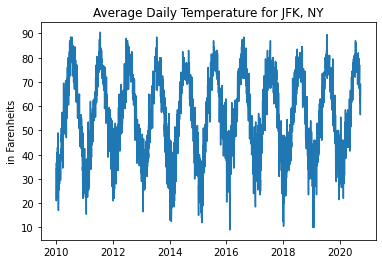

In [39]:
temperature = pd.read_csv('weather.csv', sep ='\t', engine ='python')
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
plt.plot(temperature['datetime'], temperature['temp_average'])
plt.title('Average Daily Temperature for JFK, NY');
plt.ylabel('in Farenheits');

I'll do a quick forecasting on average daily temperature using FBProphet. <br>
Training set was 2010-2017, Testing set: 2018-2020

In [40]:
_temperature = date_features(temperature.set_index('datetime')[['temp_average']])
_fb_weather = _temperature.reset_index()[['datetime', 'temp_average']]
_fb_weather.columns = ['ds', 'y']
_fb_weather.head()

,ds,y
0,2010-01-01,36.5
1,2010-01-02,25.0
2,2010-01-03,21.0
3,2010-01-04,26.0
4,2010-01-05,26.5


In [41]:
m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
m.fit(_fb_weather)

In [42]:
future = m.make_future_dataframe(periods = 365*2)
forecast = m.predict(future)

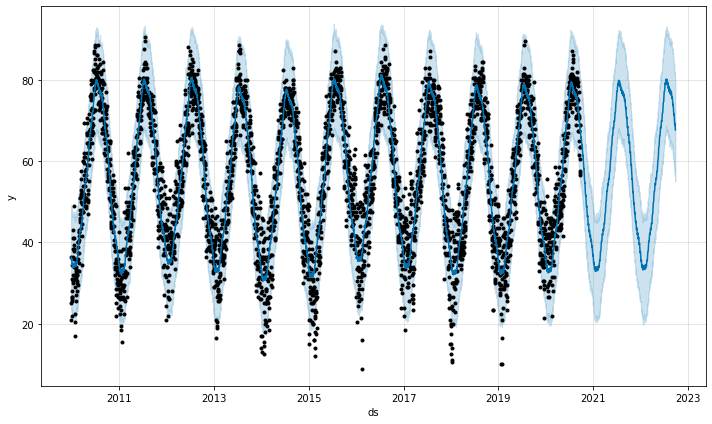

In [43]:
fig1 = m.plot(forecast)

In [44]:
sliced_forecast = forecast.loc[forecast['ds'].isin(pd.date_range(start='2018-01-01', end='2021-12-31'))]
sliced_forecast.reset_index(drop=True, inplace=True)

In [45]:
sliced_forecast = sliced_forecast[['ds', 'yhat']]
sliced_forecast.columns = ['datetime', 'temp_average']
sliced_forecast.set_index('datetime', inplace=True)
sliced_forecast.tail()

,temp_average
datetime,
2021-12-27,37.435564
2021-12-28,37.804732
2021-12-29,37.412938
2021-12-30,36.751722
2021-12-31,36.133309


In [46]:
df.tail()

,plaza_id,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday
datetime,,,,,,,,,,,,,
2018-01-01 19:00:00,Verrazano,cash,614.0,1,0,2018,1,1,1,1,-1,0,0
2018-01-01 20:00:00,Verrazano,cash,558.0,1,0,2018,1,1,1,1,-1,0,0
2018-01-01 21:00:00,Verrazano,cash,429.0,1,0,2018,1,1,1,1,-1,0,0
2018-01-01 22:00:00,Verrazano,cash,380.0,1,0,2018,1,1,1,1,-1,0,0
2018-01-01 23:00:00,Verrazano,cash,302.0,1,0,2018,1,1,1,1,-1,0,0


In [98]:
pred_set = pd.DataFrame(index = pd.date_range(start = '2020-10-11', end='2021-12-31') )
for i in crossing_rates.keys():
    pred_set[i] = np.nan
    
pred_set.reset_index(inplace=True)
pred_set.rename(columns={'index':'ds'}, inplace=True)
pred_set.set_index('ds', inplace=True)
pred_set.head()

,Brooklyn Battery_cash,Brooklyn Battery_ezpass,Cross Bay_cash,Cross Bay_ezpass,Henry Hudson_cash,Henry Hudson_ezpass,Marine Parkway_cash,Marine Parkway_ezpass,Queens Midtown_cash,Queens Midtown_ezpass,Throgs Neck_cash,Throgs Neck_ezpass,Triboro_cash,Triboro_ezpass,Verrazano_cash,Verrazano_ezpass,Whitestone_cash,Whitestone_ezpass
ds,,,,,,,,,,,,,,,,,,
2020-10-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
pred_set = date_features(pred_set)

In [100]:
pred_set

,Brooklyn Battery_cash,Brooklyn Battery_ezpass,Cross Bay_cash,Cross Bay_ezpass,Henry Hudson_cash,Henry Hudson_ezpass,Marine Parkway_cash,Marine Parkway_ezpass,Queens Midtown_cash,Queens Midtown_ezpass,...,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday
ds,,,,,,,,,,,,,,,,,,,,,
2020-10-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10,6,2020,41,11,4,285,7,1,0
2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10,0,2020,42,12,4,286,7,0,1
2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10,1,2020,42,13,4,287,7,0,0
2020-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10,2,2020,42,14,4,288,7,0,0
2020-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,2020,42,15,4,289,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,0,2021,52,27,4,361,7,0,0
2021-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,1,2021,52,28,4,362,7,0,0
2021-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2,2021,52,29,4,363,7,0,0


In [101]:
pred_fb = pd.concat([df, pred_set])

In [102]:
pred_fb = pred_fb.join(sliced_forecast)

In [103]:
pred_fb

,Brooklyn Battery_cash,Brooklyn Battery_ezpass,Cross Bay_cash,Cross Bay_ezpass,Henry Hudson_cash,Henry Hudson_ezpass,Marine Parkway_cash,Marine Parkway_ezpass,Queens Midtown_cash,Queens Midtown_ezpass,...,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
2018-01-01,3527.0,25636.0,1876.0,11829.0,5523.0,41017.0,1096.0,11022.0,7338.0,47569.0,...,0,2018,1,1,1,1,-1,0,1,34.744700
2018-01-02,4099.0,43061.0,2336.0,19539.0,5983.0,54627.0,1517.0,18370.0,6554.0,60446.0,...,1,2018,1,2,1,2,-1,0,0,35.134029
2018-01-03,4326.0,49679.0,2593.0,22014.0,6113.0,61870.0,1635.0,20432.0,7071.0,64654.0,...,2,2018,1,3,1,3,-1,0,0,34.775099
2018-01-04,1552.0,18932.0,1092.0,7211.0,1519.0,12983.0,571.0,5596.0,2687.0,23938.0,...,3,2018,1,4,1,4,-1,0,0,34.159110
2018-01-05,3103.0,34904.0,1900.0,14939.0,4700.0,45150.0,1102.0,12827.0,5465.0,49688.0,...,4,2018,1,5,1,5,-1,0,0,33.598794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2021,52,27,4,361,7,0,0,37.435564
2021-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2021,52,28,4,362,7,0,0,37.804732
2021-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2021,52,29,4,363,7,0,0,37.412938
2021-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,2021,52,30,4,364,7,0,0,36.751722


In [104]:
pred_fb.rename(index={'index': 'ds'}, inplace=True)

In [105]:
pred_fb

,Brooklyn Battery_cash,Brooklyn Battery_ezpass,Cross Bay_cash,Cross Bay_ezpass,Henry Hudson_cash,Henry Hudson_ezpass,Marine Parkway_cash,Marine Parkway_ezpass,Queens Midtown_cash,Queens Midtown_ezpass,...,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
2018-01-01,3527.0,25636.0,1876.0,11829.0,5523.0,41017.0,1096.0,11022.0,7338.0,47569.0,...,0,2018,1,1,1,1,-1,0,1,34.744700
2018-01-02,4099.0,43061.0,2336.0,19539.0,5983.0,54627.0,1517.0,18370.0,6554.0,60446.0,...,1,2018,1,2,1,2,-1,0,0,35.134029
2018-01-03,4326.0,49679.0,2593.0,22014.0,6113.0,61870.0,1635.0,20432.0,7071.0,64654.0,...,2,2018,1,3,1,3,-1,0,0,34.775099
2018-01-04,1552.0,18932.0,1092.0,7211.0,1519.0,12983.0,571.0,5596.0,2687.0,23938.0,...,3,2018,1,4,1,4,-1,0,0,34.159110
2018-01-05,3103.0,34904.0,1900.0,14939.0,4700.0,45150.0,1102.0,12827.0,5465.0,49688.0,...,4,2018,1,5,1,5,-1,0,0,33.598794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2021,52,27,4,361,7,0,0,37.435564
2021-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2021,52,28,4,362,7,0,0,37.804732
2021-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2021,52,29,4,363,7,0,0,37.412938
2021-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,2021,52,30,4,364,7,0,0,36.751722


In [107]:
tr_start,tr_end = '2018-01-01','2020-10-10'
# te_start,te_end = '2020-09-06','2020-10-10'
tra = pred_fb[tr_start:tr_end][['Brooklyn Battery_ezpass']]
# tes = _df_merged[te_start:te_end][[bridge]]
_fb_exog = pred_fb[['month', 'dayofweek', 'quarter',
       'Phase', 'weekend', 'holiday', 'temp_average']]

tra = tra.join(_fb_exog)
#     tes = tes.join(_fb_exog)


tra = tra.reset_index()
tra = tra.rename(columns = {'Brooklyn Battery_ezpass':'y', 'index': 'ds'})



m = Prophet(
       changepoint_prior_scale= 0.1,
                  holidays_prior_scale = 0.1,
                  n_changepoints = 300,
                  seasonality_mode = 'additive',
                  weekly_seasonality=True,
                  daily_seasonality = True,
                  yearly_seasonality = True,
                  interval_width=0.95)
for i in _fb_exog.columns:
    m.add_regressor(i)


m.fit(tra)
    
# # Please change the periods after changing the te_start and te_end. For this case i have made periods 35 because there are 35 days on the the test set.
# future = m.make_future_dataframe(periods=35)
# future.set_index('ds', inplace=True)
# future = future.join(_fb_exog)
# future.reset_index(inplace=True)
# pred = m.predict(future[-35:])
# _dollars = pred['yhat'].sum() * rate



In [108]:
future = m.make_future_dataframe(periods=242)
future.set_index('ds', inplace=True)
future = future.join(_fb_exog)
future.reset_index(inplace=True)
# pred = m.predict(future[-35:])

In [109]:
pred = m.predict(future)

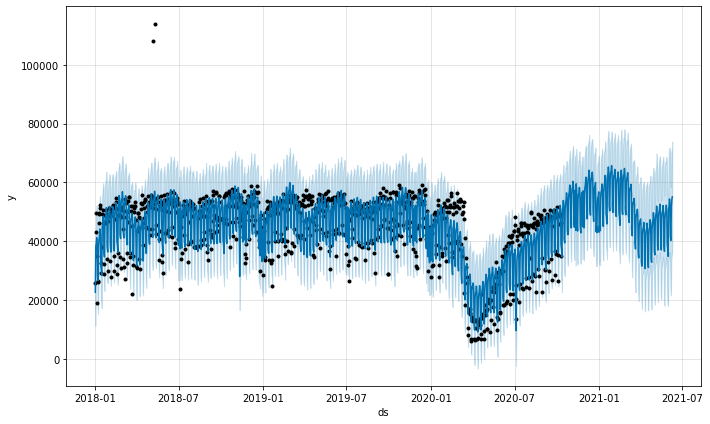

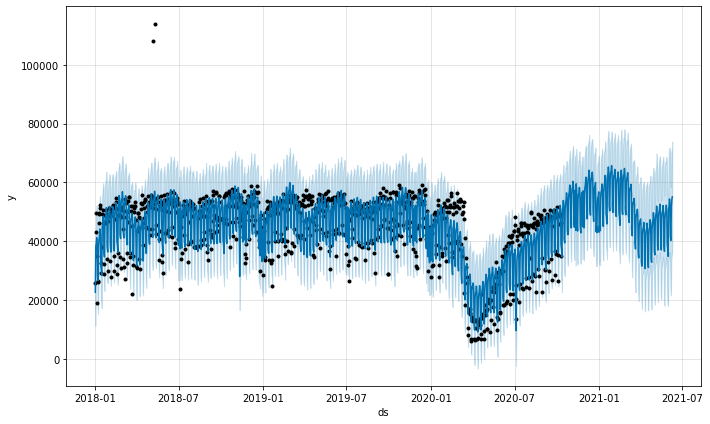

In [110]:
m.plot(pred)

In [47]:
df

,plaza_id,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday
datetime,,,,,,,,,,,,,
2020-10-10 00:00:00,Triboro,ezpass,1885.0,10,5,2020,41,10,4,284,7,1,0
2020-10-10 01:00:00,Triboro,ezpass,1290.0,10,5,2020,41,10,4,284,7,1,0
2020-10-10 02:00:00,Triboro,ezpass,828.0,10,5,2020,41,10,4,284,7,1,0
2020-10-10 03:00:00,Triboro,ezpass,741.0,10,5,2020,41,10,4,284,7,1,0
2020-10-10 04:00:00,Triboro,ezpass,863.0,10,5,2020,41,10,4,284,7,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 19:00:00,Verrazano,cash,614.0,1,0,2018,1,1,1,1,-1,0,0
2018-01-01 20:00:00,Verrazano,cash,558.0,1,0,2018,1,1,1,1,-1,0,0
2018-01-01 21:00:00,Verrazano,cash,429.0,1,0,2018,1,1,1,1,-1,0,0


In [15]:
_df = df.unstack().T
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')
_df.reset_index(inplace=True)
_df.head()

plaza_id,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone
0,2018-01-01,29163,13705,46540,12118,54907,98346,140775,81923,109286
1,2018-01-02,47160,21875,60610,19887,67000,106264,164930,95649,117211
2,2018-01-03,54005,24607,67983,22067,71725,115952,175150,103506,123974
3,2018-01-04,20484,8303,14502,6167,26625,28406,64137,37820,38114
4,2018-01-05,38007,16839,49850,13929,55153,80477,135253,74375,91229


In [63]:
_df.head()

plaza_id   datetime Brooklyn Battery        Cross Bay        Henry Hudson  \
variable                        cash ezpass      cash ezpass         cash   
0        2018-01-01             3527  25636      1876  11829         5523   
1        2018-01-02             4099  43061      2336  19539         5983   
2        2018-01-03             4326  49679      2593  22014         6113   
3        2018-01-04             1552  18932      1092   7211         1519   
4        2018-01-05             3103  34904      1900  14939         4700   

plaza_id        Marine Parkway        Queens Midtown        Throgs Neck  \
variable ezpass           cash ezpass           cash ezpass        cash   
0         41017           1096  11022           7338  47569       16177   
1         54627           1517  18370           6554  60446       12971   
2         61870           1635  20432           7071  64654       13045   
3         12983            571   5596           2687  23938        3518   
4         45150           1102  12827           5465  49688        9585   

plaza_id         Triboro         Verrazano        Whitestone          
variable  ezpass    cash  ezpass      cash ezpass       cash  ezpass  
0          82169   22395  118380     11583  70340      18818   90468  
1          93293   20751  144179      9319  86330      14843  102368  
2         102907   21182  153968      9110  94396      15263  108711  
3          24888    7787   56350      3319  34501       4855   33259  
4          70892   16429  118824      6841  67534      11586   79643

In [71]:
_df.columns

MultiIndex([(        'datetime',       ''),
            ('Brooklyn Battery',   'cash'),
            ('Brooklyn Battery', 'ezpass'),
            (       'Cross Bay',   'cash'),
            (       'Cross Bay', 'ezpass'),
            (    'Henry Hudson',   'cash'),
            (    'Henry Hudson', 'ezpass'),
            (  'Marine Parkway',   'cash'),
            (  'Marine Parkway', 'ezpass'),
            (  'Queens Midtown',   'cash'),
            (  'Queens Midtown', 'ezpass'),
            (     'Throgs Neck',   'cash'),
            (     'Throgs Neck', 'ezpass'),
            (         'Triboro',   'cash'),
            (         'Triboro', 'ezpass'),
            (       'Verrazano',   'cash'),
            (       'Verrazano', 'ezpass'),
            (      'Whitestone',   'cash'),
            (      'Whitestone', 'ezpass')],
           names=['plaza_id', 'variable'])

In [68]:
list(crossing_rates.keys())

[('Brooklyn Battery', 'cash'),
 ('Brooklyn Battery', 'ezpass'),
 ('Cross Bay', 'cash'),
 ('Cross Bay', 'ezpass'),
 ('Henry Hudson', 'cash'),
 ('Henry Hudson', 'ezpass'),
 ('Marine Parkway', 'cash'),
 ('Marine Parkway', 'ezpass'),
 ('Queens Midtown', 'cash'),
 ('Queens Midtown', 'ezpass'),
 ('Throgs Neck', 'cash'),
 ('Throgs Neck', 'ezpass'),
 ('Triboro', 'cash'),
 ('Triboro', 'ezpass'),
 ('Verrazano', 'cash'),
 ('Verrazano', 'ezpass'),
 ('Whitestone', 'cash'),
 ('Whitestone', 'ezpass')]

In [72]:
pd.melt(_df, id_vars=[(        'datetime',       '')], value_vars=list(crossing_rates.keys()))

,"(datetime, )",plaza_id,variable,value
0,2018-01-01,Brooklyn Battery,cash,3527
1,2018-01-02,Brooklyn Battery,cash,4099
2,2018-01-03,Brooklyn Battery,cash,4326
3,2018-01-04,Brooklyn Battery,cash,1552
4,2018-01-05,Brooklyn Battery,cash,3103
...,...,...,...,...
18247,2020-10-06,Whitestone,ezpass,101180
18248,2020-10-07,Whitestone,ezpass,99960
18249,2020-10-08,Whitestone,ezpass,104514
18250,2020-10-09,Whitestone,ezpass,119287


In [74]:
# I need to make the dataframe from wide to long. This can be done through pandas melt.
_df_melt = pd.melt(_df, id_vars=[('datetime','')], value_vars=list(crossing_rates.keys()))
_df_melt.columns = ['datetime', 'plaza_id', 'variable', 'value']
_df_melt.set_index('datetime', inplace=True)


In [75]:
_df_melt

,plaza_id,variable,value
datetime,,,
2018-01-01,Brooklyn Battery,cash,3527
2018-01-02,Brooklyn Battery,cash,4099
2018-01-03,Brooklyn Battery,cash,4326
2018-01-04,Brooklyn Battery,cash,1552
2018-01-05,Brooklyn Battery,cash,3103
...,...,...,...
2020-10-06,Whitestone,ezpass,101180
2020-10-07,Whitestone,ezpass,99960
2020-10-08,Whitestone,ezpass,104514


In [76]:
_df_melt['variable'] = np.where(_df_melt['variable'].eq('cash'),0, 1)

In [77]:
# LGBM doesn't take the string form in categorical values
le = LabelEncoder()
_df_melt['plaza_id'] = le.fit_transform(_df_melt['plaza_id'])


In [78]:
_df_melt = date_features(_df_melt)
_df_melt = _df_melt.join(sliced_forecast)
# There are many instances where I'll set an index to datetime and reset it.
# This is my fault for not making the data preprocessing functions take the same columns. For example: date_features takes index, while date_lag takes the column
_df_melt.reset_index(inplace=True)

In [79]:
_df_melt.tail()

,datetime,plaza_id,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
18247,2020-10-10,6,1,132258,10,5,2020,41,10,4,284,7,1,0,61.682719
18248,2020-10-10,7,0,14218,10,5,2020,41,10,4,284,7,1,0,61.682719
18249,2020-10-10,7,1,85350,10,5,2020,41,10,4,284,7,1,0,61.682719
18250,2020-10-10,8,0,26894,10,5,2020,41,10,4,284,7,1,0,61.682719
18251,2020-10-10,8,1,111136,10,5,2020,41,10,4,284,7,1,0,61.682719


In [80]:
# Copying _df_melt as training_set
train_set = _df_melt.copy(deep=True)



In [81]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19') & (_df.index < '2021-01-01'),

    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7

    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [84]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    
    _df['lag_7'] = _df[['plaza_id', 'variable', 'value']].groupby(['plaza_id', 'variable'])['value'].shift(7)
    _df['lag_28'] = _df[['plaza_id', 'variable', 'value']].groupby(['plaza_id', 'variable'])['value'].shift(28)

    
    
    _df['mean_lag7_roll7'] = _df[['plaza_id', 'variable', 'lag_7']].groupby(['plaza_id', 'variable'])['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['plaza_id', 'variable', 'lag_7']].groupby(['plaza_id', 'variable'])['lag_7'].apply(lambda x: x.rolling(28).mean())
    _df['mean_lag28_roll7'] = _df[['plaza_id', 'variable', 'lag_28']].groupby(['plaza_id', 'variable'])['lag_28'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag28_roll28'] = _df[['plaza_id', 'variable', 'lag_28']].groupby(['plaza_id', 'variable'])['lag_28'].apply(lambda x: x.rolling(28).mean())
    _df['week'] = _df['week'].astype('int64')
    
    return _df

In [85]:
train_set = date_lags(train_set)
train_set.tail()

,datetime,plaza_id,variable,value,month,dayofweek,year,week,day,quarter,...,Phase,weekend,holiday,temp_average,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
18247,2020-10-10,6,1,132258,10,5,2020,41,10,4,...,7,1,0,61.682719,130772.0,124812.0,132891.142857,131291.500000,127819.142857,128586.500000
18248,2020-10-10,7,0,14218,10,5,2020,41,10,4,...,7,1,0,61.682719,13899.0,13990.0,12421.571429,12503.607143,12892.142857,13012.535714
18249,2020-10-10,7,1,85350,10,5,2020,41,10,4,...,7,1,0,61.682719,83888.0,84897.0,84742.714286,84789.071429,83436.000000,85025.142857
18250,2020-10-10,8,0,26894,10,5,2020,41,10,4,...,7,1,0,61.682719,26227.0,25205.0,22731.428571,22628.678571,22482.714286,23056.357143
18251,2020-10-10,8,1,111136,10,5,2020,41,10,4,...,7,1,0,61.682719,104966.0,102833.0,102346.285714,101904.714286,99154.428571,102503.107143


In [86]:
categorical_features = ['plaza_id', 'month', 'dayofweek', 'year', 'week', 'day', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['value']

In [87]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)

In [88]:
X_valid = train_set.loc[train_set['datetime'] >= '2020-08-23'][train_cols]
y_valid = train_set.loc[train_set['datetime'] >= '2020-08-23']['value']
X_train = train_set.loc[train_set['datetime'] < '2020-08-23'][train_cols]
y_train = train_set.loc[train_set['datetime'] < '2020-08-23']['value']

In [89]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False) 


In [90]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 38,
    'num_leaves': 83,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.5163386620025411,
    'feature_fraction': 0.8282029364551513,
    'lambda_l1' : 0.32608335857159515,
    'lambda_l2' : 0.47993551029860304,
    'verbosity': 1

}
# params taken from optuna
# {'max_depth': 38, 'num_leaves': 83, 'bag_frac': 0.5163386620025411, 'feat_frac': 0.8282029364551513, 'l1': 0.32608335857159515, 'l2': 0.47993551029860304}

In [91]:
m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 4619.48
[200]	valid_0's rmse: 3284
[300]	valid_0's rmse: 3254.84
[400]	valid_0's rmse: 3239.17
[500]	valid_0's rmse: 3222.81
[600]	valid_0's rmse: 3239.49
[700]	valid_0's rmse: 3250.48
[800]	valid_0's rmse: 3260.88
[900]	valid_0's rmse: 3260.31
[1000]	valid_0's rmse: 3263.26
Early stopping, best iteration is:
[500]	valid_0's rmse: 3222.81


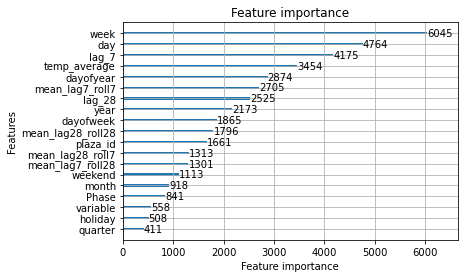

In [92]:
lgb.plot_importance(m_lgb)

### Creating the Prediction set

In [134]:
tuples = list(crossing_rates.keys())
index = pd.MultiIndex.from_tuples(tuples, names = ['plaza_id', 'variable'])

In [142]:
pred_set = pd.DataFrame(data= np.nan, index = pd.date_range(start = '2020-10-11', end='2021-03-31'), columns = index )
pred_set.reset_index(inplace=True)

In [170]:
# I need to make the dataframe from wide to long. This can be done through pandas melt.
_pred_melt = pd.melt(pred_set, id_vars=[('index','')], value_vars=tuples)
_pred_melt.rename(columns = {('index', ''):'datetime'}, inplace=True)
_pred_melt.set_index('datetime', inplace=True)
_pred_melt['plaza_id'] = le.transform(_pred_melt['plaza_id'])
_pred_melt['variable'] = np.where(_pred_melt['variable'].eq('cash'), 0, 1)
_pred_melt.tail()

,plaza_id,variable,value
datetime,,,
2021-03-27,8,1,NaN
2021-03-28,8,1,NaN
2021-03-29,8,1,NaN
2021-03-30,8,1,NaN
2021-03-31,8,1,NaN


In [171]:
def date_features_pred(_df, jan, feb, march):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19') & (_df.index < '2021-01-01'),
        # alternate each month for Q1 2021
        (_df.index >= '2021-01-01') & (_df.index < '2021-02-01'),
        (_df.index >= '2021-02-01') & (_df.index < '2021-03-01'),
        (_df.index >= '2021-03-01')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        # alternate each month for Q1 2021
        jan,
        feb,
        march
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [207]:
def pred_lgbm_dataframe(dataframe):
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = dataframe.loc[dataframe['datetime'] == (datetime.datetime(2020, 10, 10) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 10, 10) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['value'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')

    _lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-10-11', '2021-03-31'))][['datetime', 'plaza_id', 'variable', 'value']]
    # _lgbm_pred
    _lgbm_pred['plaza_id'] = le.inverse_transform(_lgbm_pred['plaza_id'])
    _lgbm_pred['variable'] = np.where(_lgbm_pred['variable'].eq(0), 'cash', 'ezpass')
    _lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns=['plaza_id', 'variable'], values='value')
    # test_set_pivot = test_set.pivot(index='datetime', columns = 'plaza_id', values='value')
    # test_set_pivot.columns = bridges
    _lgbm_pivot_pred['total'] = _lgbm_pivot_pred.sum(axis=1)

    return _lgbm_pivot_pred

### On January 01-2021: COVID over and return back to normal

In [208]:
_pred_melt_normal = date_features_pred(_pred_melt, -1, -1, -1)
_pred_melt_normal = _pred_melt_normal.join(sliced_forecast)
_pred_melt_normal.reset_index(inplace=True)
# _pred_melt_normal.rename(columns={'variable': 'plaza_id'}, inplace=True)

In [209]:
_pred_melt_normal

,datetime,plaza_id,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
0,2020-10-11,0,0,NaN,10,6,2020,41,11,4,285,7,1,0,61.568680
1,2020-10-11,0,1,NaN,10,6,2020,41,11,4,285,7,1,0,61.568680
2,2020-10-11,1,0,NaN,10,6,2020,41,11,4,285,7,1,0,61.568680
3,2020-10-11,1,1,NaN,10,6,2020,41,11,4,285,7,1,0,61.568680
4,2020-10-11,2,0,NaN,10,6,2020,41,11,4,285,7,1,0,61.568680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,2021-03-31,6,1,NaN,3,2,2021,13,31,1,90,-1,0,0,46.978244
3092,2021-03-31,7,0,NaN,3,2,2021,13,31,1,90,-1,0,0,46.978244
3093,2021-03-31,7,1,NaN,3,2,2021,13,31,1,90,-1,0,0,46.978244
3094,2021-03-31,8,0,NaN,3,2,2021,13,31,1,90,-1,0,0,46.978244


In [210]:
_pred_melt_normal_df = pred_lgbm_dataframe(_pred_melt_normal)
_pred_melt

 34%|███▍      | 172/499 [00:22<00:42,  7.63it/s]


end of loop


,plaza_id,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday
datetime,,,,,,,,,,,,,
2020-10-11,0,0,NaN,10,6,2020,41,11,4,285,7,1,0
2020-10-12,0,0,NaN,10,0,2020,42,12,4,286,7,0,1
2020-10-13,0,0,NaN,10,1,2020,42,13,4,287,7,0,0
2020-10-14,0,0,NaN,10,2,2020,42,14,4,288,7,0,0
2020-10-15,0,0,NaN,10,3,2020,42,15,4,289,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,8,1,NaN,3,5,2021,12,27,1,86,-1,1,0
2021-03-28,8,1,NaN,3,6,2021,12,28,1,87,-1,1,0
2021-03-29,8,1,NaN,3,0,2021,13,29,1,88,-1,0,0


### On January 01-2021: Continue Phase 4

In [215]:
_pred_melt_phase4

,datetime,plaza_id,plaza_id,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
0,2020-10-11,0,0,NaN,10,6,2020,41,11,4,285,7,1,0,61.568680
1,2020-10-11,0,1,NaN,10,6,2020,41,11,4,285,7,1,0,61.568680
2,2020-10-11,1,0,NaN,10,6,2020,41,11,4,285,7,1,0,61.568680
3,2020-10-11,1,1,NaN,10,6,2020,41,11,4,285,7,1,0,61.568680
4,2020-10-11,2,0,NaN,10,6,2020,41,11,4,285,7,1,0,61.568680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,2021-03-31,6,1,NaN,3,2,2021,13,31,1,90,7,0,0,46.978244
3092,2021-03-31,7,0,NaN,3,2,2021,13,31,1,90,7,0,0,46.978244
3093,2021-03-31,7,1,NaN,3,2,2021,13,31,1,90,7,0,0,46.978244
3094,2021-03-31,8,0,NaN,3,2,2021,13,31,1,90,7,0,0,46.978244


In [216]:
_pred_melt_phase4 = date_features_pred(_pred_melt, 7, 7, 7)
_pred_melt_phase4 = _pred_melt_phase4.join(sliced_forecast)
_pred_melt_phase4.reset_index(inplace=True)
# _pred_melt_phase4.rename(columns={'variable': 'plaza_id'}, inplace=True)

In [217]:
_pred_melt_phase4_df = pred_lgbm_dataframe(_pred_melt_phase4)

 34%|███▍      | 172/499 [00:19<00:36,  9.02it/s]


end of loop


### On January 01-2021: Lockdown and reopen on February

In [218]:
_pred_melt_lockdown = date_features_pred(_pred_melt, 1, 4, 7)
_pred_melt_lockdown = _pred_melt_lockdown.join(sliced_forecast)
_pred_melt_lockdown.reset_index(inplace=True)
# _pred_melt_lockdown.rename(columns={'variable': 'plaza_id'}, inplace=True)

In [219]:
_pred_melt_lockdown_df = pred_lgbm_dataframe(_pred_melt_lockdown)

 34%|███▍      | 172/499 [00:17<00:33,  9.79it/s]


end of loop


In [194]:
_df.set_index('datetime',inplace=True)
_df['Total'] = _df.sum(axis=1)
_df.reset_index(inplace=True)

In [195]:
_df

plaza_id   datetime Brooklyn Battery        Cross Bay        Henry Hudson  \
variable                        cash ezpass      cash ezpass         cash   
0        2018-01-01             3527  25636      1876  11829         5523   
1        2018-01-02             4099  43061      2336  19539         5983   
2        2018-01-03             4326  49679      2593  22014         6113   
3        2018-01-04             1552  18932      1092   7211         1519   
4        2018-01-05             3103  34904      1900  14939         4700   
...             ...              ...    ...       ...    ...          ...   
1009     2020-10-06             7093  48860      3385  18802         7695   
1010     2020-10-07             7090  48514      3227  18876         8126   
1011     2020-10-08             7313  49405      3313  19392         8370   
1012     2020-10-09             7540  46132      3402  19839        10035   
1013     2020-10-10             6316  34818      3177  16757        10105   

plaza_id        Marine Parkway        Queens Midtown        Throgs Neck  \
variable ezpass           cash ezpass           cash ezpass        cash   
0         41017           1096  11022           7338  47569       16177   
1         54627           1517  18370           6554  60446       12971   
2         61870           1635  20432           7071  64654       13045   
3         12983            571   5596           2687  23938        3518   
4         45150           1102  12827           5465  49688        9585   
...         ...            ...    ...            ...    ...         ...   
1009      52157           2518  18667          10831  52764       14178   
1010      53803           2476  17918          11425  56360       14752   
1011      55294           2559  18748          11800  58204       15760   
1012      60207           2531  17999          13433  61760       17321   
1013      51852           2605  16447          12107  48178       19018   

plaza_id         Triboro         Verrazano        Whitestone            Total  
variable  ezpass    cash  ezpass      cash ezpass       cash  ezpass           
0          82169   22395  118380     11583  70340      18818   90468  1173526  
1          93293   20751  144179      9319  86330      14843  102368  1401172  
2         102907   21182  153968      9110  94396      15263  108711  1517938  
3          24888    7787   56350      3319  34501       4855   33259   489116  
4          70892   16429  118824      6841  67534      11586   79643  1110224  
...          ...     ...     ...       ...    ...        ...     ...      ...  
1009       83961   26219  130693     11193  86130      20675  101180  1394002  
1010       86849   26443  134036     11166  86913      20208   99960  1416284  
1011       90958   28160  140175     11907  88834      21469  104514  1472350  
1012       95125   30816  142961     13464  93085      25545  119287  1560964  
1013       91976   32227  132258     14218  85350      26894  111136  1430878  

[1014 rows x 20 columns]

In [46]:
_df.set_index('datetime', inplace=True)

In [53]:
_actual_229 = 0
for i in ['Cross Bay', 'Marine Parkway']:
    _actual_229 += _df['2019-01-01':'2019-03-31'][i].sum() * 2.29

In [55]:
_actual_612 = 0
for i in ['Brooklyn Battery', 'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone']:
    _actual_612 += _df['2019-01-01':'2019-03-31'][i].sum() * 6.12

In [56]:
# Henry Hudson
_actual_280 = _df['2019-01-01':'2019-03-31']['Henry Hudson'].sum() * 2.80

In [57]:
_actual_229 + _actual_612 + _actual_280

378200118.79999995

### Calculating total Dollars

In [44]:
_norm_229 = 0
_pred_melt_normal_df['2021':]['Triboro']

13618657.527289728

In [58]:
_norm_229 = 0
for i in ['Cross Bay', 'Marine Parkway']:
    _norm_229 += _pred_melt_normal_df['2021-01-01':'2021-03-31'][i].sum() * 2.29
    
_norm_612 = 0
for i in ['Brooklyn Battery', 'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone']:
    _norm_612 += _pred_melt_normal_df['2021-01-01':'2021-03-31'][i].sum() * 6.12
    
# Henry Hudson
_norm_280 = _pred_melt_normal_df['2021-01-01':'2021-03-31']['Henry Hudson'].sum() * 2.80

In [59]:
_norm_229 + _norm_612 + _norm_280

350171492.42677516

In [67]:
_cont_229 = 0
for i in ['Cross Bay', 'Marine Parkway']:
    _cont_229 += _pred_melt_phase4_df['2021-01-01':'2021-03-31'][i].sum() * 2.29
    
_cont_612 = 0
for i in ['Brooklyn Battery', 'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone']:
    _cont_612 += _pred_melt_phase4_df['2021-01-01':'2021-03-31'][i].sum() * 6.12
    
# Henry Hudson
_cont_280 = _pred_melt_phase4_df['2021-01-01':'2021-03-31']['Henry Hudson'].sum() * 2.80

In [68]:
_cont_229 + _cont_612 + _cont_280

336123629.908748

In [69]:
_lock_229 = 0
for i in ['Cross Bay', 'Marine Parkway']:
    _lock_229 += _pred_melt_lockdown_df['2021-01-01':'2021-03-31'][i].sum() * 2.29
    
_lock_612 = 0
for i in ['Brooklyn Battery', 'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone']:
    _lock_612 += _pred_melt_lockdown_df['2021-01-01':'2021-03-31'][i].sum() * 6.12
    
# Henry Hudson
_lock_280 = _pred_melt_lockdown_df['2021-01-01':'2021-03-31']['Henry Hudson'].sum() * 2.80

In [70]:
_lock_229 + _lock_612 + _lock_280

221347823.97535586

In [40]:
train_roll = train_set.copy(deep=True)
try:
    for i in tqdm(range(1,500)):
        _to_pred = _pred_melt.loc[_pred_melt['datetime'] == (datetime.datetime(2020, 9, 26) + datetime.timedelta(days= i))].copy()
        _first_concat = pd.concat([train_roll, _to_pred])
        _first_concat.reset_index(inplace=True, drop=True)
        _first_concat = date_lags(_first_concat)
        _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 26) + datetime.timedelta(days= i))].copy()
        _to_pred_feats = _to_pred[train_cols]
        first_pred = m_lgb.predict(_to_pred_feats)
        _to_pred['value'] = first_pred
        train_roll = pd.concat([train_roll, _to_pred])
except:
    print('end of loop')

  0%|          | 0/499 [00:00<?, ?it/s]


end of loop


In [76]:
_df.reset_index(inplace=True)

In [77]:
_df.set_index('datetime', inplace=True)
_df['total'] = _df.sum(axis=1)
_df.reset_index(inplace=True)
# _df

In [197]:

_2019_Q1_mean = _df.loc[(_df['datetime'] >= '2019-01-01') & (_df['datetime'] <= '2019-03-31')]['Total'].mean()
_2019_Q1_mean

1496094.177777778

In [198]:
_pred_melt_phase4_df['2021':]

plaza_id   Brooklyn Battery                  Cross Bay                \
variable               cash        ezpass         cash        ezpass   
datetime                                                               
2021-01-01      5410.263043  38702.944369  3269.187590  17185.993231   
2021-01-02      4851.515231  36134.686628  3133.173237  15547.828989   
2021-01-03      4607.773770  34667.324471  2827.710445  14244.138137   
2021-01-04      4141.889826  41033.499584  2831.806787  15973.150239   
2021-01-05      4522.214448  44271.037325  2910.481533  16082.583592   
...                     ...           ...          ...           ...   
2021-03-27      4780.103064  34610.007743  2731.533485  15244.372466   
2021-03-28      4499.162314  36213.988524  2707.775206  15232.571187   
2021-03-29      4709.423833  46341.862016  3091.546410  18785.328193   
2021-03-30      4561.332698  47236.900117  3008.835616  19526.157081   
2021-03-31      4593.117407  45403.680022  3002.097497  18964.616829   

plaza_id   Henry Hudson               Marine Parkway                \
variable           cash        ezpass           cash        ezpass   
datetime                                                             
2021-01-01  9166.481265  44663.063866    2315.957266  17215.677465   
2021-01-02  8909.067939  36894.580477    2207.122872  15328.468358   
2021-01-03  7444.882282  36097.341636    2095.431784  14167.981419   
2021-01-04  6202.368537  41447.788281    1996.080751  15621.229874   
2021-01-05  6001.918955  44630.981760    2133.735903  16238.800810   
...                 ...           ...            ...           ...   
2021-03-27  6606.953252  41350.344657    1583.801083  14551.392995   
2021-03-28  6278.134125  39486.869891    1630.598934  15327.971945   
2021-03-29  6227.712407  50918.460340    1683.998290  18859.938041   
2021-03-30  6306.328720  50954.699467    1682.456044  18968.515861   
2021-03-31  6340.668559  49656.878257    1729.089735  18944.009579   

plaza_id   Queens Midtown                 Throgs Neck                \
variable             cash        ezpass          cash        ezpass   
datetime                                                              
2021-01-01   11329.005707  45379.761855  15686.893325  93663.155600   
2021-01-02   11143.426490  37187.934445  15026.821050  86859.138772   
2021-01-03   10763.665498  36319.342212  13834.612001  80939.718831   
2021-01-04    9685.945273  43673.500892  11738.237144  79690.218008   
2021-01-05    9791.877650  46428.377758  11442.242072  83267.277787   
...                   ...           ...           ...           ...   
2021-03-27   10407.812758  41805.877879  12512.192614  92264.139609   
2021-03-28   10727.579889  39042.185727  13404.051621  95274.611542   
2021-03-29    9939.156193  50683.362165  11908.126484  94853.054599   
2021-03-30    9799.578200  51024.587053  11985.505481  95288.707366   
2021-03-31    9699.470478  49613.446980  11770.186853  92781.605994   

plaza_id         Triboro                    Verrazano                \
variable            cash         ezpass          cash        ezpass   
datetime                                                              
2021-01-01  25473.957219  115251.553267  11911.910118  80399.218742   
2021-01-02  26433.153272  113690.452519  11435.599526  81373.178742   
2021-01-03  23362.289132  108598.928977  10786.495326  69115.310334   
2021-01-04  21110.990287  113063.869297   9122.877854  75077.977651   
2021-01-05  22113.153545  113705.607989   9207.924301  76798.158984   
...                  ...            ...           ...           ...   
2021-03-27  25991.917043  122989.858618  10437.418340  60140.736693   
2021-03-28  23398.385078  116327.859264  10728.545138  60351.662792   
2021-03-29  22852.568278  127414.362029   9667.717913  66126.576034   
2021-03-30  22260.598645  131011.276436   9673.195680  65193.927629   
2021-03-31  21936.928557  129002.574890   9473.253382  66353.926017   

plaza_id      Whites

In [204]:
_pred_melt_lockdown_df['2020-12-31':]

plaza_id   Brooklyn Battery                  Cross Bay                \
variable               cash        ezpass         cash        ezpass   
datetime                                                               
2020-12-31      5043.936315  45131.307828  3270.634993  17028.051642   
2021-01-01      5410.263043  38702.944369  3269.187590  17185.993231   
2021-01-02      4851.515231  36134.686628  3133.173237  15547.828989   
2021-01-03      4607.773770  34667.324471  2827.710445  14244.138137   
2021-01-04      4141.889826  41033.499584  2831.806787  15973.150239   
...                     ...           ...          ...           ...   
2021-03-27      4780.103064  34610.007743  2731.533485  15244.372466   
2021-03-28      4499.162314  36213.988524  2707.775206  15232.571187   
2021-03-29      4709.423833  46341.862016  3091.546410  18785.328193   
2021-03-30      4561.332698  47236.900117  3008.835616  19526.157081   
2021-03-31      4593.117407  45403.680022  3002.097497  18964.616829   

plaza_id   Henry Hudson               Marine Parkway                \
variable           cash        ezpass           cash        ezpass   
datetime                                                             
2020-12-31  7896.601580  45648.337334    2333.674867  17080.513228   
2021-01-01  9166.481265  44663.063866    2315.957266  17215.677465   
2021-01-02  8909.067939  36894.580477    2207.122872  15328.468358   
2021-01-03  7444.882282  36097.341636    2095.431784  14167.981419   
2021-01-04  6202.368537  41447.788281    1996.080751  15621.229874   
...                 ...           ...            ...           ...   
2021-03-27  6606.953252  41350.344657    1583.801083  14551.392995   
2021-03-28  6278.134125  39486.869891    1630.598934  15327.971945   
2021-03-29  6227.712407  50918.460340    1683.998290  18859.938041   
2021-03-30  6306.328720  50954.699467    1682.456044  18968.515861   
2021-03-31  6340.668559  49656.878257    1729.089735  18944.009579   

plaza_id   Queens Midtown                 Throgs Neck                \
variable             cash        ezpass          cash        ezpass   
datetime                                                              
2020-12-31   11022.488533  50088.440638  13801.310294  87921.365879   
2021-01-01   11329.005707  45379.761855  15686.893325  93663.155600   
2021-01-02   11143.426490  37187.934445  15026.821050  86859.138772   
2021-01-03   10763.665498  36319.342212  13834.612001  80939.718831   
2021-01-04    9685.945273  43673.500892  11738.237144  79690.218008   
...                   ...           ...           ...           ...   
2021-03-27   10407.812758  41805.877879  12512.192614  92264.139609   
2021-03-28   10727.579889  39042.185727  13404.051621  95274.611542   
2021-03-29    9939.156193  50683.362165  11908.126484  94853.054599   
2021-03-30    9799.578200  51024.587053  11985.505481  95288.707366   
2021-03-31    9699.470478  49613.446980  11770.186853  92781.605994   

plaza_id         Triboro                    Verrazano                \
variable            cash         ezpass          cash        ezpass   
datetime                                                              
2020-12-31  24505.532459  120691.560489  10796.726192  87596.839052   
2021-01-01  25473.957219  115251.553267  11911.910118  80399.218742   
2021-01-02  26433.153272  113690.452519  11435.599526  81373.178742   
2021-01-03  23362.289132  108598.928977  10786.495326  69115.310334   
2021-01-04  21110.990287  113063.869297   9122.877854  75077.977651   
...                  ...            ...           ...           ...   
2021-03-27  25991.917043  122989.858618  10437.418340  60140.736693   
2021-03-28  23398.385078  116327.859264  10728.545138  60351.662792   
2021-03-29  22852.568278  127414.362029   9667.717913  66126.576034   
2021-03-30  22260.598645  131011.276436   9673.195680  65193.927629   
2021-03-31  21936.928557  129002.574890   9473.253382  66353.926017   

plaza_id      Whites

(50000.0, 950000.0)

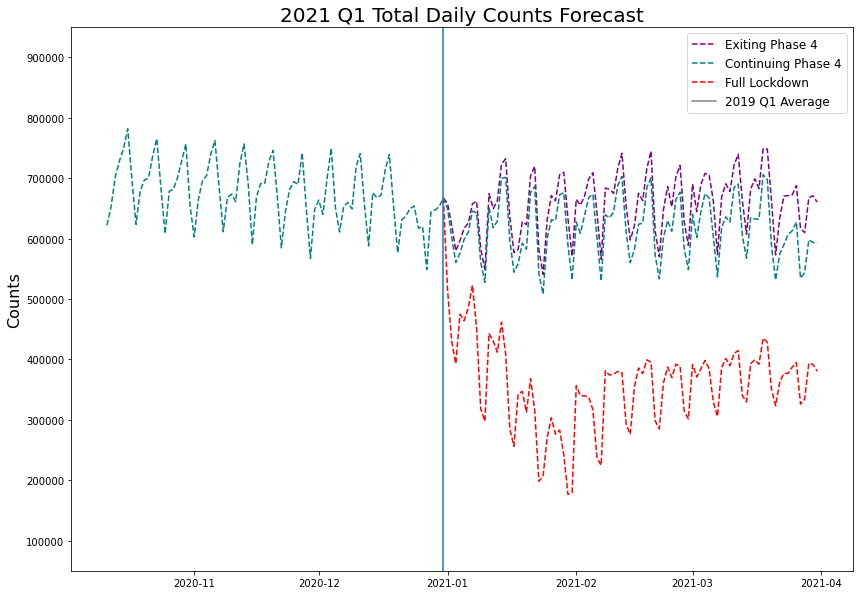

In [220]:
plt.figure(figsize=(14,10))
# plt.plot(sliced_plotting['Day_of_Year'], sliced_plotting['total'], label = '2019 actual')

plt.plot(_pred_melt_normal_df['2020-12-31':].index, _pred_melt_normal_df['2020-12-31':]['total'], label = 'Exiting Phase 4', color = 'purple',linewidth=1.5, linestyle = '--')
plt.plot(_pred_melt_phase4_df.index, _pred_melt_phase4_df['total'], label = 'Continuing Phase 4', color = 'teal',linewidth=1.5, linestyle = '--')
plt.plot(_pred_melt_lockdown_df['2020-12-31':].index, _pred_melt_lockdown_df['2020-12-31':]['total'], label = 'Full Lockdown', color = 'red',linewidth=1.5, linestyle = '--')
# plt.plot(_pred_melt_lockdown_df[:'2020-12-31'].index, _pred_melt_lockdown_df[:'2020-12-31']['total'], color = 'orange', linestyle = '--')
# Draw pivot line
plt.axvline(pd.to_datetime('2020-12-31'))
# Draw 2019 Q1 average counts
plt.axhline(_2019_Q1_mean, color='grey', label = '2019 Q1 Average')
plt.legend(loc = 'upper right', prop={'size': 12})
plt.title('2021 Q1 Total Daily Counts Forecast', fontsize=20)
plt.ylabel('Counts', fontsize=16)
plt.ylim(50000, 950000)
# plt.savefig('2021Q1forecast', bbox_inches ='tight', pad_inches=0.5);

In [44]:
_2019_Q1_sum = _df.loc[(_df['datetime'] >= '2019-01-01') & (_df['datetime'] <= '2019-03-31')]['total'].sum()
_2019_Q1_sum

67324238

In [45]:
_pred_melt_normal_df['2021-01-01':]['total'].sum()

62437709.956466906

In [46]:
_pred_melt_phase4_df['2021-01-01':]['total'].sum()

59917217.139752604

In [48]:
_pred_melt_lockdown_df['2021-01-01':]['total'].sum()

38760724.39606447

In [88]:
_2020_pred = _pred_melt_phase4_df.copy(deep=True)
_actual = _df.copy(deep=True)
_actual.set_index('datetime', inplace=True)
_2020_pred['dayofyear'] = _2020_pred.index.dayofyear
_actual['dayofyear'] = _actual.index.dayofyear

In [89]:
_actual['2019-01-01':'2019-12-31']

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,total,dayofyear
datetime,,,,,,,,,,,
2019-01-01,32230,14627,47739,13571,59462,96937,135134,83742,112301,595743,1
2019-01-02,48068,22600,62609,20122,70871,109748,160710,100674,122673,718075,2
2019-01-03,52421,23462,65233,21583,72222,111448,168800,102714,125141,743024,3
2019-01-04,52650,24178,68276,21379,73413,114423,171435,104293,128479,758526,4
2019-01-05,37276,18274,52617,15030,61060,101257,140806,89136,113044,628500,5
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,47674,20901,67397,19433,73799,117317,179065,108885,137894,772365,361
2019-12-28,41165,17922,65985,16325,69772,120621,169005,105031,131937,737763,362
2019-12-29,40876,15156,58086,14769,64920,107968,154170,96541,124100,676586,363


In [90]:
_2020_pred[:'2020-12-31']['total'].mean()

702264.8003868255

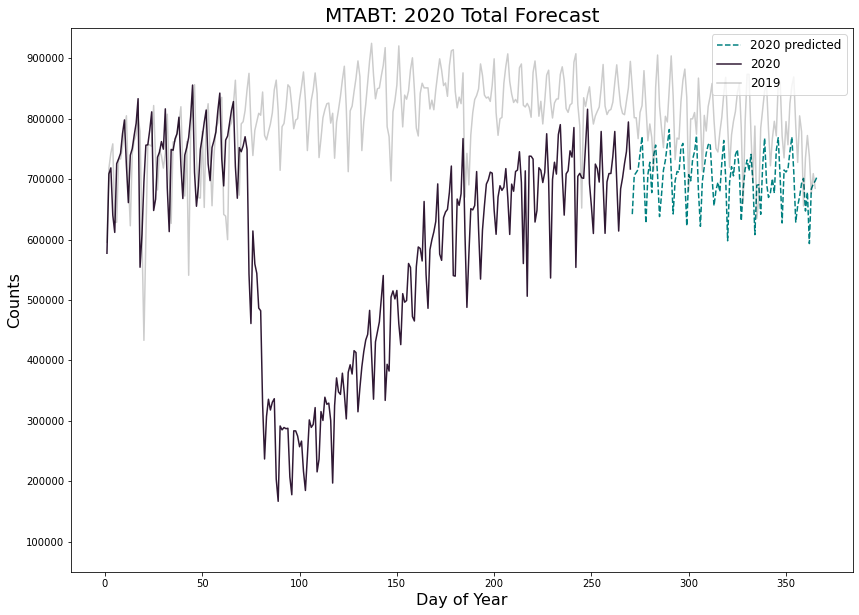

In [97]:


plt.figure(figsize=(14,10))
plt.plot(_2020_pred[:'2020-12-31']['dayofyear'], _2020_pred[:'2020-12-31']['total'], color = 'teal', linewidth=1.5,linestyle = '--', label= '2020 predicted')
plt.plot(_actual['2020-01-01':]['dayofyear'], _actual['2020-01-01':]['total'], color = '#301934',label = '2020')

plt.plot(_actual['2019-01-01':'2019-12-31']['dayofyear'], _actual['2019-01-01':'2019-12-31']['total'], color = 'black', alpha = 0.2, label = '2019')
plt.legend(loc='upper right', prop={'size': 12})
plt.xlabel('Day of Year', fontsize=16)
plt.ylabel('Counts', fontsize =16)
plt.ylim(50_000, 950_000)
plt.title('MTABT: 2020 Total Forecast', fontsize=20)
# _percent_change = (_2020_pred[:'2020-12-31']['total'].mean() - _actual['2019-01-01':'2019-12-31']['total'].mean())/_actual['2019-01-01':'2019-12-31']['total'].mean() * 100
# plt.annotate('{:.2f}%'.format(_percent_change), xy=(0.55, 0.10), xycoords='axes fraction', fontsize=70, color = 'orange')
plt.savefig('Total_forecast', bbox_inches ='tight', pad_inches=0.5)


In [98]:
pred_set_far = pd.DataFrame(index = pd.date_range(start = '2020-09-27', end='2021-12-31') )
for i in bridges:
    pred_set_far[i] = np.nan
    
pred_set_far.reset_index(inplace=True)
pred_set_far.rename(columns={'index':'datetime'}, inplace=True)
pred_set_far.tail()

,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone
456,2021-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,2021-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,2021-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
459,2021-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
460,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
_pred_melt_phase4_df

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,total
datetime,,,,,,,,,,
2020-09-27,38018.675960,18933.434857,52183.212710,18558.828581,52772.957028,110162.670869,142622.105993,84166.173766,124683.498649,642101.558414
2020-09-28,51362.858236,20728.248465,57998.586890,19840.701269,66660.244136,106652.878246,164566.931643,96015.154356,122642.748280,706468.351521
2020-09-29,51219.153493,20714.258985,59379.076219,20406.806203,67516.281526,104427.221875,161354.284375,99212.446272,126778.023851,711007.552799
2020-09-30,49175.201071,21691.530443,62983.408857,20920.249248,67959.452765,104613.672935,165690.607463,98789.782629,124373.945458,716197.850869
2020-10-01,53481.193254,21616.728209,67718.844969,20621.191658,74400.352668,107882.583469,170427.837770,99609.865434,127066.082734,742824.680166
...,...,...,...,...,...,...,...,...,...,...
2021-03-27,41442.761116,19143.076394,51194.000858,17183.908072,59493.711726,102658.930363,146373.217282,92421.814964,112022.324456,641933.745233
2021-03-28,41735.215968,17594.745888,45593.946434,16434.238353,56579.645276,99069.219122,134681.606863,82419.458242,107600.808664,601708.884810
2021-03-29,50788.560730,22250.947503,57088.673635,20100.375953,64482.766044,103706.166574,136967.028021,90968.672867,109325.574148,655678.765475


In [138]:
forecast_avg_bridges = []
for i in bridges:
    forecast_avg_bridges.append((_pred_melt_phase4_df['2021':][i].mean(), i))

In [139]:
forecast_avg_bridges

[(50233.07837482333, 'Brooklyn Battery'),
 (20764.639291365616, 'Cross Bay'),
 (56323.89184903462, 'Henry Hudson'),
 (19096.573653358537, 'Marine Parkway'),
 (66407.48088122647, 'Queens Midtown'),
 (101821.54703443164, 'Throgs Neck'),
 (147806.27663695678, 'Triboro'),
 (92277.43288724328, 'Verrazano'),
 (111015.93649992201, 'Whitestone')]

In [142]:
_2019_avg_bridges = []
for i in bridges:
    _2019_avg_bridges.append((_actual['2019-01-01':'2019-03-31'][i].mean(),i))

In [143]:
_2019_avg_bridges

[(51980.955555555556, 'Brooklyn Battery'),
 (21494.022222222222, 'Cross Bay'),
 (66096.16666666667, 'Henry Hudson'),
 (19337.666666666668, 'Marine Parkway'),
 (79188.12222222223, 'Queens Midtown'),
 (113509.32222222222, 'Throgs Neck'),
 (172507.03333333333, 'Triboro'),
 (98719.66666666667, 'Verrazano'),
 (125214.13333333333, 'Whitestone')]

In [150]:
for forecast, actual in zip(forecast_avg_bridges, _2019_avg_bridges):
    print(forecast[1],' : ',(forecast[0] - actual[0])/ actual[0])

Brooklyn Battery  :  -0.03362533762704981
Cross Bay  :  -0.03393422242313082
Henry Hudson  :  -0.14784934301735178
Marine Parkway  :  -0.012467533827321343
Queens Midtown  :  -0.1613959389658211
Throgs Neck  :  -0.10296753569639777
Triboro  :  -0.14318695428868433
Verrazano  :  -0.06525785587562818
Whitestone  :  -0.11339132776340999


### Forecasting all of 2021
Given that NYC stays in Phase 4 for the rest of the year, forecast all of 2021. <br>
_This idea has been scrapped._

In [103]:
# I need to make the dataframe from wide to long. This can be done through pandas melt.
_pred_far_melt = pd.melt(pred_set_far, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone'])
_pred_far_melt.set_index('datetime', inplace=True)
_pred_far_melt['variable'] = le.transform(_pred_far_melt['variable'])
_pred_far_melt.tail()

,variable,value
datetime,,
2021-12-27,8,NaN
2021-12-28,8,NaN
2021-12-29,8,NaN
2021-12-30,8,NaN
2021-12-31,8,NaN


In [104]:
# _pred_far_melt.reset_index(inplace=True)

In [105]:

_pred_far_melt = date_features_pred(_pred_far_melt, 7, 7, 7)
_pred_far_melt = _pred_far_melt.join(sliced_forecast)
_pred_far_melt.reset_index(inplace=True)
_pred_far_melt.rename(columns={'variable': 'plaza_id'}, inplace=True)
_pred_far_melt

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
0,2020-09-27,0,NaN,9,6,2020,39,27,3,271,7,1,0,65.803486
1,2020-09-27,1,NaN,9,6,2020,39,27,3,271,7,1,0,65.803486
2,2020-09-27,2,NaN,9,6,2020,39,27,3,271,7,1,0,65.803486
3,2020-09-27,3,NaN,9,6,2020,39,27,3,271,7,1,0,65.803486
4,2020-09-27,4,NaN,9,6,2020,39,27,3,271,7,1,0,65.803486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,2021-12-31,4,NaN,12,4,2021,52,31,4,365,7,0,1,36.133309
4145,2021-12-31,5,NaN,12,4,2021,52,31,4,365,7,0,1,36.133309
4146,2021-12-31,6,NaN,12,4,2021,52,31,4,365,7,0,1,36.133309
4147,2021-12-31,7,NaN,12,4,2021,52,31,4,365,7,0,1,36.133309


In [110]:
def pred_far_dataframe(dataframe):
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = dataframe.loc[dataframe['datetime'] == (datetime.datetime(2020, 9, 26) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 26) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['value'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')

    _lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-27', '2021-12-31'))][['datetime', 'plaza_id', 'value']]
    # _lgbm_pred
    _lgbm_pred['plaza_id'] = le.inverse_transform(_lgbm_pred['plaza_id'])
    _lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='plaza_id', values='value')
    # test_set_pivot = test_set.pivot(index='datetime', columns = 'plaza_id', values='value')
    # test_set_pivot.columns = bridges
    _lgbm_pivot_pred['total'] = _lgbm_pivot_pred.sum(axis=1)

    return _lgbm_pivot_pred

In [111]:
_pred_far_df = pred_far_dataframe(_pred_far_melt)

 92%|█████████▏| 461/499 [00:36<00:03, 12.50it/s]


end of loop


In [112]:
_pred_far_df

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,total
datetime,,,,,,,,,,
2020-09-27,38018.675960,18933.434857,52183.212710,18558.828581,52772.957028,110162.670869,142622.105993,84166.173766,124683.498649,642101.558414
2020-09-28,51362.858236,20728.248465,57998.586890,19840.701269,66660.244136,106652.878246,164566.931643,96015.154356,122642.748280,706468.351521
2020-09-29,51219.153493,20714.258985,59379.076219,20406.806203,67516.281526,104427.221875,161354.284375,99212.446272,126778.023851,711007.552799
2020-09-30,49175.201071,21691.530443,62983.408857,20920.249248,67959.452765,104613.672935,165690.607463,98789.782629,124373.945458,716197.850869
2020-10-01,53481.193254,21616.728209,67718.844969,20621.191658,74400.352668,107882.583469,170427.837770,99609.865434,127066.082734,742824.680166
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,49930.575513,19986.125756,62125.882414,19516.324297,65662.737706,106329.062936,166610.571086,105339.912678,126067.160847,721568.353232
2021-12-28,49927.960863,19741.399558,60091.325067,18983.341091,64840.588810,109335.804274,164062.622564,105910.544806,126910.212007,719803.799040
2021-12-29,51694.743958,19904.035029,62814.132887,18948.352707,65845.066122,110902.528977,166489.432215,107061.343829,127581.908298,731241.544021


Text(0.5, 1.0, 'MTA Total Count: 2021 Forecast vs 2019 Actual')

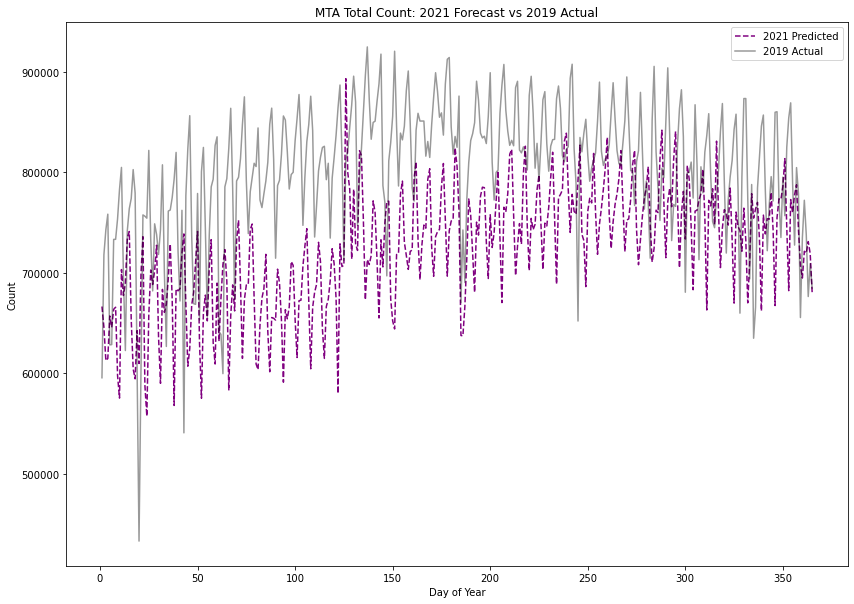

In [129]:
plt.figure(figsize=(14,10))
plt.plot(_pred_far_df['2021':].index.dayofyear, _pred_far_df['2021':]['total'], color = 'purple', linestyle='--', label = '2021 Predicted')
plt.plot(_actual['2019-01-01':'2019-12-31']['dayofyear'], (_actual['2019-01-01':'2019-12-31']['total']), color='black', alpha=0.4,label = '2019 Actual')
plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Count')
plt.title('MTA Total Count: 2021 Forecast vs 2019 Actual')